<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Check for GPU
!nvidia-smi

Mon Feb 13 18:27:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1+cu116


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.



*   Increase model complexity, i.e. add more layers to a neural network.
*   Gather more data for training.
*   Use transfer learning



## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

Random image path: data/pizza_steak_sushi/test/pizza/2019408.jpg
Image class: pizza
Image height: 512
Image width: 512


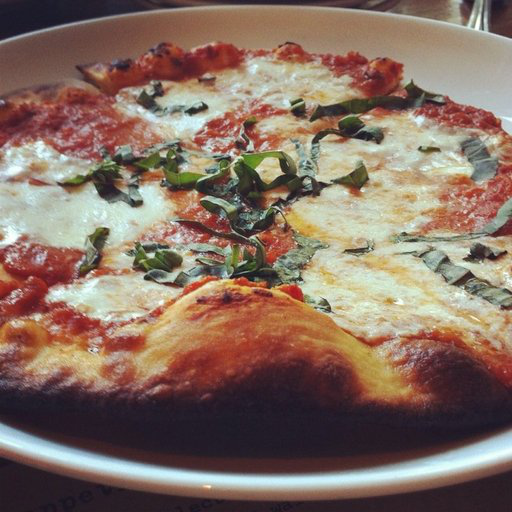

In [7]:
# Visualize an image
import random
from PIL import Image

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

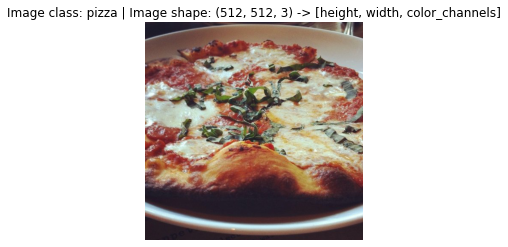

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import datasets, transforms

img_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

### Load image data using `ImageFolder`

In [10]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=img_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=img_transforms)

In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [16]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} [NCHW]")

Image shape: torch.Size([1, 3, 64, 64]) [NCHW]


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [36]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = nn.Dropout(p=0.5)(x)
      # print(x.shape)
      x = self.conv_block_2(x)
      x = nn.Dropout(p=0.5)(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x

tiny_vgg = TinyVGG(input_shape=3,
                   hidden_units=20,
                   output_shape=len(train_data.classes))

## 4. Create training and testing functions for `model_0`.

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss_fn(y_pred, y).item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss = loss.item()

      # Calculate and accumulate accuracy
      pred_labels = y_pred.argmax(dim=1)
      test_acc += ((pred_labels == y)).sum().item()/len(pred_labels)
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

In [26]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  #return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [28]:
num_epochs = [5, 20, 30]

for epochs in num_epochs: 

  tiny_vgg = TinyVGG(input_shape=3, hidden_units=30, 
                     output_shape=len(train_data.classes))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=tiny_vgg.parameters(), 
                             lr=0.001)

  train(model=tiny_vgg, loss_fn=loss_fn, optimizer=optimizer, 
      train_dataloader=train_dataloader, test_dataloader=test_dataloader, 
      epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1085 | train_acc: 0.2773 | test_loss: 0.3588 | test_acc: 0.3693
Epoch: 2 | train_loss: 1.1098 | train_acc: 0.2891 | test_loss: 0.3538 | test_acc: 0.3911
Epoch: 3 | train_loss: 1.0831 | train_acc: 0.5469 | test_loss: 0.3724 | test_acc: 0.2396
Epoch: 4 | train_loss: 1.0515 | train_acc: 0.5000 | test_loss: 0.4738 | test_acc: 0.2708
Epoch: 5 | train_loss: 1.0490 | train_acc: 0.5039 | test_loss: 0.3698 | test_acc: 0.3513


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1051 | train_acc: 0.3750 | test_loss: 0.3847 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0481 | train_acc: 0.4258 | test_loss: 0.4210 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0909 | train_acc: 0.3320 | test_loss: 0.3898 | test_acc: 0.3021
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.4414 | test_loss: 0.3405 | test_acc: 0.4223
Epoch: 5 | train_loss: 1.0231 | train_acc: 0.4219 | test_loss: 0.3232 | test_acc: 0.5426
Epoch: 6 | train_loss: 0.9756 | train_acc: 0.4258 | test_loss: 0.3076 | test_acc: 0.4233
Epoch: 7 | train_loss: 0.8167 | train_acc: 0.6016 | test_loss: 0.4754 | test_acc: 0.2907
Epoch: 8 | train_loss: 0.8989 | train_acc: 0.5156 | test_loss: 0.2279 | test_acc: 0.5634
Epoch: 9 | train_loss: 0.7911 | train_acc: 0.5742 | test_loss: 0.3841 | test_acc: 0.3731
Epoch: 10 | train_loss: 0.7921 | train_acc: 0.6797 | test_loss: 0.4535 | test_acc: 0.3419
Epoch: 11 | train_loss: 0.8525 | train_acc: 0.5508 | test_loss: 0.3898 | test_acc: 0.4441
Epoch: 12 | train_l

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1150 | train_acc: 0.2773 | test_loss: 0.3870 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1058 | train_acc: 0.3086 | test_loss: 0.3732 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1026 | train_acc: 0.2930 | test_loss: 0.3814 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0922 | train_acc: 0.2930 | test_loss: 0.3718 | test_acc: 0.2812
Epoch: 5 | train_loss: 1.0818 | train_acc: 0.3477 | test_loss: 0.3540 | test_acc: 0.2396
Epoch: 6 | train_loss: 1.0445 | train_acc: 0.4453 | test_loss: 0.3088 | test_acc: 0.5322
Epoch: 7 | train_loss: 1.0034 | train_acc: 0.4141 | test_loss: 0.2814 | test_acc: 0.5739
Epoch: 8 | train_loss: 0.9444 | train_acc: 0.5352 | test_loss: 0.5499 | test_acc: 0.2604
Epoch: 9 | train_loss: 0.9177 | train_acc: 0.5703 | test_loss: 0.4026 | test_acc: 0.4536
Epoch: 10 | train_loss: 1.0175 | train_acc: 0.4023 | test_loss: 0.3725 | test_acc: 0.4432
Epoch: 11 | train_loss: 0.8979 | train_acc: 0.6055 | test_loss: 0.4079 | test_acc: 0.3314
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [29]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [30]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images... 

In [31]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [32]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_dataset_20 = ImageFolder(root=train_data_20_percent_path,
                               transform=simple_transform)
test_dataset_20 = ImageFolder(root=test_data_20_percent_path,
                              transform=simple_transform)

# Create dataloaders
train_dataloader_20 = DataLoader(train_dataset_20, 
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

test_dataloader_20 = DataLoader(test_dataset_20, 
                                batch_size=BATCH_SIZE,
                                shuffle=False)



In [54]:
# Train a model with increased amount of data

tiny_vgg = TinyVGG(input_shape=3, hidden_units=20, 
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg.parameters(), 
                             lr=0.001)

train(model=tiny_vgg, loss_fn=loss_fn, optimizer=optimizer, 
      train_dataloader=train_dataloader_20, test_dataloader=test_dataloader_20, 
      epochs=20)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1037 | train_acc: 0.3312 | test_loss: 0.2157 | test_acc: 0.3688
Epoch: 2 | train_loss: 1.0717 | train_acc: 0.4021 | test_loss: 0.1418 | test_acc: 0.4693
Epoch: 3 | train_loss: 1.0145 | train_acc: 0.4625 | test_loss: 0.1650 | test_acc: 0.5017
Epoch: 4 | train_loss: 0.9400 | train_acc: 0.5542 | test_loss: 0.2261 | test_acc: 0.5170
Epoch: 5 | train_loss: 0.9125 | train_acc: 0.5729 | test_loss: 0.2095 | test_acc: 0.5472
Epoch: 6 | train_loss: 0.9452 | train_acc: 0.5312 | test_loss: 0.2802 | test_acc: 0.4932
Epoch: 7 | train_loss: 0.9455 | train_acc: 0.5146 | test_loss: 0.2007 | test_acc: 0.5097
Epoch: 8 | train_loss: 0.8923 | train_acc: 0.5833 | test_loss: 0.2348 | test_acc: 0.5312
Epoch: 9 | train_loss: 0.8570 | train_acc: 0.5917 | test_loss: 0.2235 | test_acc: 0.5284
Epoch: 10 | train_loss: 0.8215 | train_acc: 0.6292 | test_loss: 0.2736 | test_acc: 0.5267
Epoch: 11 | train_loss: 0.8478 | train_acc: 0.6312 | test_loss: 0.2291 | test_acc: 0.5193
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [53]:
steak_url = "https://www.seriouseats.com/thmb/WzQz05gt5witRGeOYKTcTqfe1gs=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/butter-basted-pan-seared-steaks-recipe-hero-06-03b1131c58524be2bd6c9851a2fbdbc3.jpg"

steak_img = requests.get(steak_url).content

with open("steak_test.jpg", "wb") as file:
  file.write(steak_img)

transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.PILToTensor()
])

steak_test = Image.open("steak_test.jpg")
steak_tensor = transform(steak_test).unsqueeze(dim=0).to(dtype=torch.float32)

tiny_vgg.eval()

with torch.inference_mode():
  pred = tiny_vgg(steak_tensor).argmax(dim=1)
  pred_label = train_data.classes[pred]

pred_label

'pizza'